# Predict Gamma to use the model with the other base models in stacking

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost
import optuna
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from copy import deepcopy
from sklearn.metrics import confusion_matrix, log_loss, average_precision_score, multilabel_confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
folder = '/home/olli/Projects/Kaggle/ICR'

In [3]:
train_csv = 'train.csv'
greek_csv = 'greeks.csv'
test_csv = 'test.csv'

In [4]:
train_csv_path = os.path.join(folder, train_csv)
greek_csv_path = os.path.join(folder, greek_csv)

In [5]:
df = pd.read_csv(train_csv_path)
df_g = pd.read_csv(greek_csv_path)

# Preprocess Pipeline

In [6]:
cat_features = ['EJ']
num_features = list(df.columns)
for remove_value in ['Id', 'EJ', 'Class']:
    num_features.remove(remove_value)

In [7]:
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

In [8]:
# use a standardscaler due to the outliers
scaler_num = StandardScaler()

In [9]:
encoder_cat = OneHotEncoder(sparse_output=False)

In [10]:
num_pipeline = Pipeline([
    ('Num_Imputer', imputer_num),
    ('Num_Scaler', scaler_num)
])

In [11]:
cat_pipeline = Pipeline([
    ('Cat_Imputer', imputer_cat),
    ('Cat_Encoder', encoder_cat)
])

In [12]:
preprocess_pipe = ColumnTransformer([
    ('Num_Pipe', num_pipeline, num_features),
    ('Cat_Pipe', cat_pipeline, cat_features)
])

In [13]:
# merge dfs; use same split like in final training
X_DF = df.copy()
X_DF['Alpha'] = df_g.Alpha
X_DF['Gamma'] = df_g.Gamma

In [14]:
X_DF.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Gamma
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,G
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,M
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,M
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,M
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,F


Recall from Notebook_1: Gamma_M had the highest correlation with the Target and most datapoints were gamma_M. gamma_H also has a high correlation but were less datapoints.

# Function to add the multi-label

In [15]:
# Problem: The target is a pd series and need to be converted to a multi class numpy array

def create_gamma_label(series, onehot=True):
    df = series.copy()
    
    class_labels = []
    
    # for each values add the class number (M==0, H==1, other==2)
    for value in df.values:
        if value == 'M':
            class_labels.append(0)
        elif value == 'H':
            class_labels.append(1)
        else:
            class_labels.append(2)
            
    # since this is a multiclass classification the labels need to be like this:
    # [1, 0, 0] for [gamma_M, gamma_H, gamma_other]
    labels_onehot = []
    
    for label in class_labels:
        labels_onehot.append(np.eye(3)[label])  # makes easy onehot
    
    labels_onehot = np.array(labels_onehot)
    
    if onehot:
        return labels_onehot
    else:
        return np.array(class_labels)

In [16]:
# check the function
exp_gamma = X_DF['Gamma'].copy()

In [17]:
exp_gamma.head(n=15)

0     G
1     M
2     M
3     M
4     F
5     M
6     M
7     M
8     M
9     M
10    F
11    N
12    N
13    E
14    M
Name: Gamma, dtype: object

In [18]:
exp_gamma_encoded = create_gamma_label(exp_gamma)

In [19]:
exp_gamma_encoded[:15]

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [20]:
# Also calculate the initial weights to try
exp_gamma.value_counts()

M    445
N     64
H     53
B     18
A     11
F     10
G      8
E      8
Name: Gamma, dtype: int64

In [21]:
len(exp_gamma)

617

In [22]:
exp_gamma_enc_2 = create_gamma_label(exp_gamma, onehot=False)

In [23]:
exp_gamma_enc_2[:15]

array([2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0])

In [24]:
len(np.unique(exp_gamma_enc_2))

3

In [25]:
# set weight M to 1
# weight H
print(f'H: {445 / 53}; other: {445 / (617 - 445 - 53)}' )

H: 8.39622641509434; other: 3.7394957983193278


# Optimize Hyperparameters

In [26]:
def objective(trial):
    
    # weights
    weight_M = trial.suggest_float('weight_M', 0.7, 1.5)
    weight_H = trial.suggest_float('weight_H', 6, 11)
    weight_other = trial.suggest_float('weight_other', 3, 4.5)
    
    # use the auc score here with weighted param for the imbalanced task and to utilize propapilities
    scores = []

    seeds = list(range(0, 10))

    for seed in seeds:

        cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        # use alpha+gamma to draw stratified samples
        for train_index, valid_index in cv.split(X_DF, X_DF[['Alpha', 'Gamma']].copy()):

            # take all columns for the features since the ColumnTransformer will only select the defined ones
            X_train, y_train = X_DF.iloc[train_index], X_DF.loc[train_index, 'Gamma']
            X_valid, y_valid = X_DF.iloc[valid_index], X_DF.loc[valid_index, 'Gamma']

            # use defined pipeline
            X_train = preprocess_pipe.fit_transform(X_train)
            X_valid = preprocess_pipe.transform(X_valid)  # no fit

            # apply function to add labels
            y_train = create_gamma_label(y_train, onehot=False)
            y_valid = create_gamma_label(y_valid, onehot=False)
            
            # create the sample weight to assign an individual weight for each point
            dict_weight = {0:weight_M, 1:weight_H, 2: weight_other}
            sample_weights = np.array([dict_weight[i] for i in y_train])
            
            xgb = xgboost.XGBClassifier(n_estimators=trial.suggest_int('n_estimators', 5, 1000),
                                        max_depth=trial.suggest_int('max_depth', 2, 10),
                                        learning_rate=trial.suggest_float('lr', 0.01, 1),
                                        gamma=trial.suggest_float('gamma', 0, 1),
                                        min_child_weight=trial.suggest_float('min_child_weight', 0, 10),
                                        max_delta_step=trial.suggest_int('max_delta_step', 0, 10),
                                        subsample=trial.suggest_float('subsample', 0.5, 1),
                                        colsample_bynode=trial.suggest_float('colsample_bynode', 0.5, 1),
                                        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1),
                                        colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.5, 1),
                                        reg_lambda=trial.suggest_float('reg_lambda', 0.0001, 0.1, log=True),
                                        objective='multi:softprob',
                                        num_class=3,
                                        #sample_weight=sample_weights,
                                        )
            xgb.fit(X_train,
                    y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    sample_weight=sample_weights,
                    early_stopping_rounds=trial.suggest_int('early_stop', 1, 1000),
                    verbose=0
                    )

            xgb.fit(X_train, y_train)

            y_val_pred = xgb.predict_proba(X_valid)  # currently (n_samples, 3) for 3 classes
            
            # y_valid is (n_samples, ) for xgb, metric needs onehot
            y_valid_onehot = np.eye(len(np.unique(y_valid)))[y_valid]
                        
            score = average_precision_score(y_valid_onehot, y_val_pred, average='weighted')
            scores.append(score)

    final_score = np.array(scores).mean()

    return final_score

In [27]:
study = optuna.create_study(direction='maximize')

[I 2023-08-10 11:11:07,513] A new study created in memory with name: no-name-8a6db963-6020-4abb-b8bb-2f67528ce4b7


In [28]:
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [29]:
# rerun..
#%%time
#study.optimize(objective, n_trials=200, show_progress_bar=True)

In [30]:
#study.best_value

0.9138

In [31]:
#study.best_params

# Run 2

In [32]:
def objective_2(trial):
    
    # weights
    weight_M = trial.suggest_float('weight_M', 1.2, 1.7)
    weight_H = trial.suggest_float('weight_H', 5, 7)
    weight_other = trial.suggest_float('weight_other', 3.25, 4.25)
    
    # use the auc score here with weighted param for the imbalanced task and to utilize propapilities
    scores = []

    seeds = list(range(0, 10))

    for seed in seeds:

        cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        # use alpha+gamma to draw stratified samples
        for train_index, valid_index in cv.split(X_DF, X_DF[['Alpha', 'Gamma']].copy()):

            # take all columns for the features since the ColumnTransformer will only select the defined ones
            X_train, y_train = X_DF.iloc[train_index], X_DF.loc[train_index, 'Gamma']
            X_valid, y_valid = X_DF.iloc[valid_index], X_DF.loc[valid_index, 'Gamma']

            # use defined pipeline
            X_train = preprocess_pipe.fit_transform(X_train)
            X_valid = preprocess_pipe.transform(X_valid)  # no fit

            # apply function to add labels
            y_train = create_gamma_label(y_train, onehot=False)
            y_valid = create_gamma_label(y_valid, onehot=False)
            
            # create the sample weight to assign an individual weight for each point
            dict_weight = {0:weight_M, 1:weight_H, 2: weight_other}
            sample_weights = np.array([dict_weight[i] for i in y_train])
            
            xgb = xgboost.XGBClassifier(n_estimators=trial.suggest_int('n_estimators', 850, 910),
                                        max_depth=3,
                                        learning_rate=trial.suggest_float('lr', 0.02, 0.1),
                                        gamma=trial.suggest_float('gamma', 0.05, 0.25),
                                        min_child_weight=trial.suggest_float('min_child_weight', 0.6, 1),
                                        max_delta_step=trial.suggest_int('max_delta_step', 6, 10),
                                        subsample=trial.suggest_float('subsample', 0.5, 0.7),
                                        colsample_bynode=trial.suggest_float('colsample_bynode', 0.85, 1),
                                        colsample_bytree=trial.suggest_float('colsample_bytree', 0.75, 0.95),
                                        colsample_bylevel=trial.suggest_float('colsample_bylevel', 0.4, 0.6),
                                        reg_lambda=trial.suggest_float('reg_lambda', 0.1, 10, log=True),
                                        objective='multi:softprob',
                                        num_class=3,
                                        #sample_weight=sample_weights,
                                        )
            xgb.fit(X_train,
                    y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    sample_weight=sample_weights,
                    early_stopping_rounds=trial.suggest_int('early_stop', 200, 260),
                    verbose=0
                    )

            xgb.fit(X_train, y_train)

            y_val_pred = xgb.predict_proba(X_valid)  # currently (n_samples, 3) for 3 classes
            
            # y_valid is (n_samples, ) for xgb, metric needs onehot
            y_valid_onehot = np.eye(len(np.unique(y_valid)))[y_valid]
                        
            score = average_precision_score(y_valid_onehot, y_val_pred, average='weighted')
            scores.append(score)

    final_score = np.array(scores).mean()

    return final_score

In [33]:
study_2 = optuna.create_study(direction='maximize')

In [34]:
#%%time
#study_2.optimize(objective_2, n_trials=40, show_progress_bar=True)

In [35]:
#study_2.best_value

0.91545

In [36]:
#study_2.best_params

# Error Analysis

In [37]:
# weights to train later
weight_M = 1.6574709291749559
weight_H = 6.494618704275055
weight_other = 4.141839934777784

xgb_gamma_params = {
         'n_estimators': 904,
         'max_depth': 3,
         'learning_rate': 0.025917942386337954,
         'gamma': 0.23400159239280982,
         'min_child_weight': 0.8473270431776004,
         'max_delta_step': 9,
         'subsample': 0.5309248067433621,
         'colsample_bynode': 0.9777134591145428,
         'colsample_bytree': 0.8372737842373374,
         'colsample_bylevel': 0.5711105969683837,
         'reg_lambda': 0.10145045118989354,
         'objective': 'multi:softprob',
         'num_class': 3}

In [38]:
# use the auc score here with weighted param for the imbalanced task and to utilize propapilities
targets = []
predictions = []

scores = []

seeds = list(range(0, 10))

for seed in tqdm(seeds):

    cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # use alpha+gamma to draw stratified samples
    for train_index, valid_index in cv.split(X_DF, X_DF[['Alpha', 'Gamma']].copy()):

        # take all columns for the features since the ColumnTransformer will only select the defined ones
        X_train, y_train = X_DF.iloc[train_index], X_DF.loc[train_index, 'Gamma']
        X_valid, y_valid = X_DF.iloc[valid_index], X_DF.loc[valid_index, 'Gamma']

        # use defined pipeline
        X_train = preprocess_pipe.fit_transform(X_train)
        X_valid = preprocess_pipe.transform(X_valid)  # no fit

        # apply function to add labels
        y_train = create_gamma_label(y_train, onehot=False)
        y_valid = create_gamma_label(y_valid, onehot=False)

        # create the sample weight to assign an individual weight for each point
        dict_weight = {0:weight_M, 1:weight_H, 2: weight_other}
        sample_weights = np.array([dict_weight[i] for i in y_train])

        xgb = xgboost.XGBClassifier(**xgb_gamma_params)
        
        xgb.fit(X_train,
                y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                sample_weight=sample_weights,
                early_stopping_rounds=218,
                verbose=0
                )

        xgb.fit(X_train, y_train)

        y_val_pred = xgb.predict_proba(X_valid)  # currently (n_samples, 3) for 3 classes

        # y_valid is (n_samples, ) for xgb, metric needs onehot
        y_valid_onehot = np.eye(len(np.unique(y_valid)))[y_valid]

        targets.append(y_valid_onehot)
        predictions.append(y_val_pred)
        
        score = average_precision_score(y_valid_onehot, y_val_pred, average='weighted')
        scores.append(score)

final_score = np.array(scores).mean()

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
final_score

0.915451209159391

In [40]:
len(targets)

50

In [41]:
len(predictions)

50

In [42]:
targets[0].shape

(123, 3)

In [43]:
predictions[0].shape

(123, 3)

In [44]:
# merge them together
targets_stack = np.concatenate(targets, axis=0)
print(targets_stack.shape)

(6170, 3)


In [45]:
predictions_stack = np.concatenate(predictions, axis=0)

In [46]:
# for a single conf matrix classes are needed not 1hot
targets_class = np.array([np.argmax(i) for i in targets_stack])

In [47]:
predictions_class = np.array([np.argmax(i) for i in predictions_stack])

In [48]:
conf_matrix = confusion_matrix(targets_class, predictions_class)

In [49]:
conf_matrix

array([[4252,   55,  143],
       [ 101,  335,   94],
       [ 477,   76,  637]])

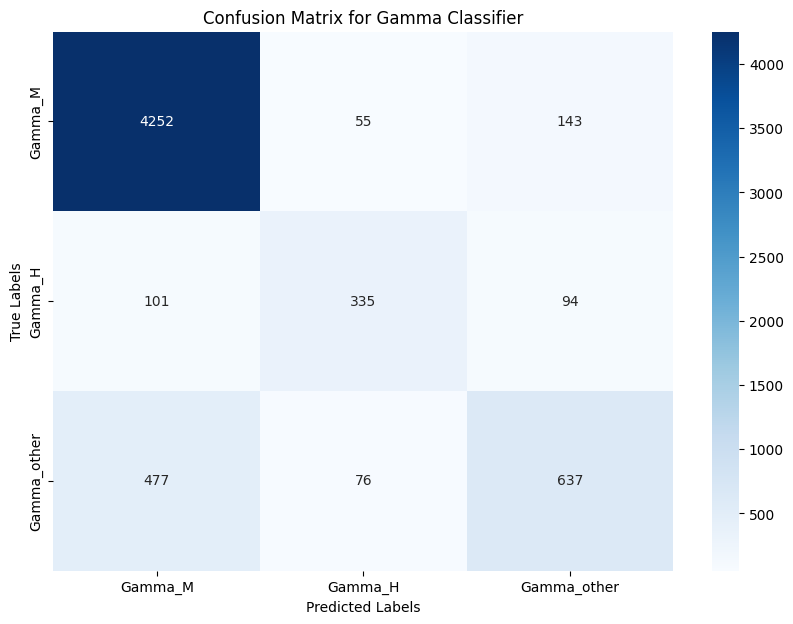

In [50]:
figure = plt.figure(figsize=(10, 7))
class_labels = ['Gamma_M', 'Gamma_H', 'Gamma_other']
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gamma Classifier')
plt.show()